In [1]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision as tv
import torchvision.transforms as transforms
from torchvision import models
import numpy as np

from adaAcos import AdaAcos

if torch.cuda.is_available():
    device = "cuda"
    print("CUDA-Capable GPU available, using GPU!")
else:
    device = "cpu"
    print("Using CPU Backend.")

CUDA-Capable GPU available, using GPU!


In [2]:
def evaluate(model, loader, mode="Validation"):
    features_list = []
    ident_list = []
    num_steps = loader.__len__()
    
    #Infer emb_extractor over all testsamples
    model.emb_extract.train(False)
    with torch.set_grad_enabled(False):
        for i, data in enumerate(loader):
            inputs, labels = data[0].to(device), data[1].to("cpu")
            features = model.emb_extract(inputs*2 - 1).to("cpu")
            features_list += features
            ident_list += labels
            print(f'{mode} Step: {i+1}/{num_steps}', end="\r")
    features_list = torch.stack(features_list)
    ident_list = torch.stack(ident_list)
    num_classes = ident_list.max().item()+1
    model.emb_extract.train(True)
    
    # Create Class-Centers by computing the mean for each class
    print("Generating classweightvectors...",end="\r")
    class_weights = []
    for i in range(num_classes):
        class_weights.append(F.normalize(torch.mean(features_list[ident_list==i], axis= 0), 2, 0))
    class_weights = torch.stack(class_weights)
    
    # Compute classification probabilitys for each sample using said class-centers
    class_probabilities = features_list@class_weights.T
    accuracy = torch.where(ident_list==torch.argmax(class_probabilities,axis=1), 1.0, 0.0).mean().item()
    print(f"{mode} Accuracy: {100*accuracy:.3f}%                ",end="")
    return accuracy

In [3]:
def imshow(img):
    img = img.numpy()
    plt.imshow(np.transpose(img, (1,2,0)))

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

trainset = tv.datasets.EMNIST(root="../Datasets/", split="balanced", download=True, train=True, transform=transform)#, split="letters"
testset = tv.datasets.EMNIST(root="../Datasets/", split="balanced", download=True, train=False, transform=transform)

In [5]:
batch_size = 128
num_classes = 47
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=8)

torch.Size([128, 1, 28, 28]) tensor(46)
tensor(-1.) tensor(1.)


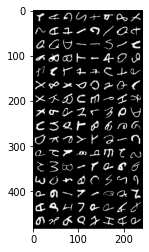

In [6]:
imgs, lbls = next(iter(trainloader))
print(imgs.shape,lbls.max())
print(imgs.min(),imgs.max())
imshow(tv.utils.make_grid(imgs.clip(0,1)))

In [7]:
convnet = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
    nn.LeakyReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.LeakyReLU(),
    nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
    nn.LeakyReLU(),
    nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
    nn.LeakyReLU(),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten(1),
)
print(f"Param Size: {sum(p.numel() for p in convnet.parameters() if p.requires_grad)/1000000:.3f} Million")

Param Size: 0.388 Million


In [8]:
class embExtract(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = convnet
        self.dropout = nn.Dropout(0.2)
        self.features = nn.Linear(256, 3)

    def forward(self, x):
        x = self.backbone(x)
        x = self.dropout(x)
        x = self.features(x)
        x = F.normalize(x, 2, 1)
        return x

class adaAcosNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb_extract = embExtract()
        self.classifyer = AdaAcos(3, num_classes)#nn.Linear(32,10)#

    def forward(self, x, y=None):
        x = self.emb_extract(x)
        x = self.classifyer(x, y)
        return x

model = adaAcosNet().to(device)

model

autoscale s set to 18.818030192593184


adaAcosNet(
  (emb_extract): embExtract(
    (backbone): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): LeakyReLU(negative_slope=0.01)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): LeakyReLU(negative_slope=0.01)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): LeakyReLU(negative_slope=0.01)
      (8): AdaptiveAvgPool2d(output_size=(1, 1))
      (9): Flatten(start_dim=1, end_dim=-1)
    )
    (dropout): Dropout(p=0.2, inplace=False)
    (features): Linear(in_features=256, out_features=3, bias=True)
  )
  (classifyer): AdaAcos()
)

In [9]:
log_train = ([], [], [], [])
log_val = ([], [])
c = 0

In [10]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)# 5e-4
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.05, steps_per_epoch=882, epochs=20)
#optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

In [11]:
num_epochs = 20
trainSteps = trainloader.__len__()
valSteps = testloader.__len__()

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}")
    model.train(True)
    for i, data in enumerate(trainloader):
        c +=1
        inputs, labels = data[0].to(device), data[1].to(device)
        y = F.one_hot(labels, num_classes=num_classes)

        optimizer.zero_grad()
        logits = model(inputs, y)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        #metric
        correct = torch.sum(torch.where(torch.argmax(F.log_softmax(logits,1), dim=1) == labels, 1, 0)).item()
        acc = correct/(labels.shape[0])

        l = loss.item()

        print(f'Step: {i+1}/{trainSteps} loss: {l:2.3f} Accuracy: {100*acc:3.3f}%  LR: {scheduler.get_last_lr()[0]:1.5f} Margin: {model.classifyer.m:1.2f}', end="\r")# AdaCos Scale: {model.classifyer.s.item():.2f} Theta_m: {model.classifyer.theta_med:.2f} B_avg: {model.classifyer.B_avg:.2f}', end="\r")
        log_train[0].append(c)
        log_train[1].append(l)
        log_train[2].append(acc)
        log_train[3].append(model.classifyer.m)
    
    print("")#newline
    log_val[0].append(c)
    #Using the evaluate function on the emb_extract Networkpart instead of the trained classification layer will give worse results, but be a better measure of class compactness
    log_val[1].append(evaluate(model, testloader))

print('\nFinished Training')


Epoch 1
Step: 882/882 loss: 3.060 Accuracy: 9.375%  LR: 0.00522 Margin: 0.000
Validation Accuracy: 17.777%                
Epoch 2
Step: 882/882 loss: 1.354 Accuracy: 43.750%  LR: 0.01400 Margin: 0.00
Validation Accuracy: 41.745%                
Epoch 3
Step: 882/882 loss: 1.110 Accuracy: 53.125%  LR: 0.02601 Margin: 0.03
Validation Accuracy: 60.117%                
Epoch 4
Step: 882/882 loss: 1.226 Accuracy: 50.000%  LR: 0.03801 Margin: 0.06
Validation Accuracy: 60.128%                
Epoch 5
Step: 882/882 loss: 1.177 Accuracy: 50.000%  LR: 0.04679 Margin: 0.04
Validation Accuracy: 63.521%                
Epoch 6
Step: 882/882 loss: 2.670 Accuracy: 50.000%  LR: 0.05000 Margin: 0.10
Validation Accuracy: 71.133%                
Epoch 7
Step: 882/882 loss: 1.774 Accuracy: 50.000%  LR: 0.04937 Margin: 0.17
Validation Accuracy: 69.282%                
Epoch 8
Step: 882/882 loss: 1.097 Accuracy: 53.125%  LR: 0.04752 Margin: 0.11
Validation Accuracy: 69.277%                
Epoch 9
Step: 8

## Classification Accuracy (blue) capped at 0.5

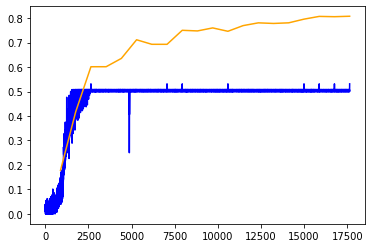

In [12]:
plt.plot(log_train[0], log_train[2], color='blue')
plt.plot(log_val[0], log_val[1], color='orange')
plt.show()

## Margin parameter during Training

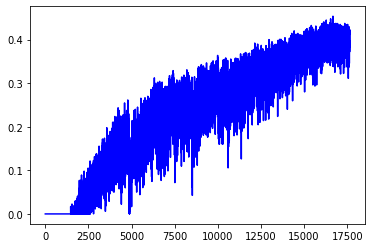

In [13]:
plt.plot(log_train[0], log_train[3], color='blue')

In [14]:
y_test = []
y_emb = []
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    emb = list(model.emb_extract(inputs.to("cuda")).to("cpu").detach().numpy())
    y_emb += emb
    y_test += list(labels.detach().numpy())
y_test, y_emb = np.array(y_test), np.array(y_emb)

### Lets look at the distribution of the classes on the 3D-Hypersphere (using Test-Samples)

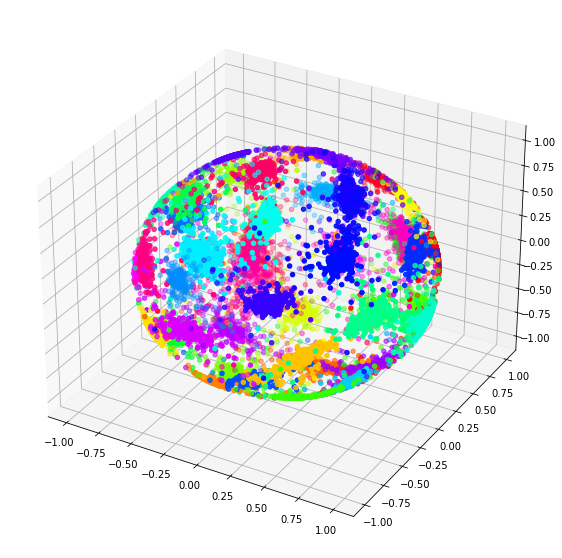

In [15]:
import matplotlib.pyplot as plt
import colorsys

%matplotlib inline # change from "inline" to "qt" to rotate sphere in Qt-Window

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

for i in range(num_classes):
    points = y_emb[y_test.squeeze() == i]
    color = colorsys.hsv_to_rgb((i+1)/num_classes,1,1)
    #plt.scatter(points[:,0],points[:,1],color=color)
    ax.scatter(points[:,0], points[:,1], points[:,2], color=color)

plt.show()